# Part of speech classification 

## Install all the packages

In [1]:
!pip3 install -r requirements.txt



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Imports

In [3]:
%load_ext autoreload
%autoreload 2

from drTorch.model_selection import grid_search_train_validation
from drTorch.utilities import get_data_loader, plot_history
from drTorch.metrics import F1_Score
from drTorch.wrappers import OptimizerWrapper
from drTorch.wrappers import Criterion
from drTorch.callbacks import EarlyStopper

import torch

from models.baseline_model import BaselineModel
from models.model_1 import Model1
from models.model_2 import Model2

from utilities import *

import joblib, itertools
import numpy as np
import os

from sklearn.metrics import confusion_matrix


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's set the device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: %s' % device)


Device: cuda


In [5]:
!nvidia-smi


Wed Dec 13 15:18:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8               3W /  80W |   4256MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [6]:
# Directories and File Paths
DATA_DIRECTORY = 'dependency_treebank'  # Directory containing the dataset
DATASET = 'merged_dataset.csv'  # Name of the dataset file
RESULT_DIRECTORY = 'results'  # Directory to store the results

WEIGHTS_DIRECTORY = os.path.join(RESULT_DIRECTORY, 'weights')  # Directory to store model weights

# File paths for grid search results
BASELINE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, 'BaseLine_grid_search_model.pkl')
MODEL_1_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, 'Model_1_grid_search_model.pkl')
MODEL_2_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, 'Model_2_grid_search_model.pkl')

# File paths for model weights
BASELINE_WEIGHTS_PATH = os.path.join(WEIGHTS_DIRECTORY, 'baseline_wights.pth')
MODEL_1_WEIGHTS_PATH = os.path.join(WEIGHTS_DIRECTORY, 'model_1_wights.pth')
MODEL_2_WEIGHTS_PATH = os.path.join(WEIGHTS_DIRECTORY, 'model_2_wights.pth')

# Path to the dataset
DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)

# Data Splits
TRAIN_BOUNDS = 1, 100  # Range of indices for the training set
VALIDATION_BOUNDS = 101, 150  # Range of indices for the validation set
TEST_BOUNDS = 151, 199  # Range of indices for the test set
BATCH_SIZE = 32  # Batch size for training

# Word Embedding Parameters
GLOVE_MODEL_VERSION = '840B'  # Version of the GloVe word embedding model
EMBEDDING_DIMENSION = 300  # Dimension of the word embeddings

# Bounds for Random Initialization of Weights
LOW = -0.5  # Lower bound for random weight initialization
HIGH = 0.5  # Upper bound for random weight initialization

# Flags to control execution flow
FIRST_LOAD = True  # Flag to indicate whether it's the first load of data

RUN_BASELINE_GRID_SEARCH = True  # Flag to run grid search for baseline model
RUN_MODEL_1_GRID_SEARCH = True  # Flag to run grid search for model 1
RUN_MODEL_2_GRID_SEARCH = True  # Flag to run grid search for model 2

FIT_BASELINE = True  # Flag to fit the baseline model
FIT_MODEL_1 = True  # Flag to fit model 1
FIT_MODEL_2 = True  # Flag to fit model 2

## Task 1

### Loading and splitting the data

In [7]:
if FIRST_LOAD:
    df = merge_data(DATA_DIRECTORY)
    df.to_csv(DATASET_PATH, index=False)  
    print(f'The merged dataset has been saved in {DATASET_PATH}')
else:
    df = pd.read_csv(DATASET_PATH)
    print(f'The merged dataset has been loaded from {DATASET_PATH}')

train_df, val_df, test_df = split_dataset(df, TRAIN_BOUNDS, VALIDATION_BOUNDS, TEST_BOUNDS )  


100%|██████████| 199/199 [00:00<00:00, 1238.71it/s]


The merged dataset has been saved in dependency_treebank/merged_dataset.csv


### Let's take a look to the data

In [8]:
train_df.head(20)


,WORD,POS,INFO,SOURCE_FILE
0,Pierre,NNP,2,wsj_0001.dp
1,Vinken,NNP,8,wsj_0001.dp
2,",",",",2,wsj_0001.dp
3,61,CD,5,wsj_0001.dp
4,years,NNS,6,wsj_0001.dp
5,old,JJ,2,wsj_0001.dp
6,",",",",2,wsj_0001.dp
7,will,MD,0,wsj_0001.dp
8,join,VB,8,wsj_0001.dp
9,the,DT,11,wsj_0001.dp


#### Let's plot the Word Cloud

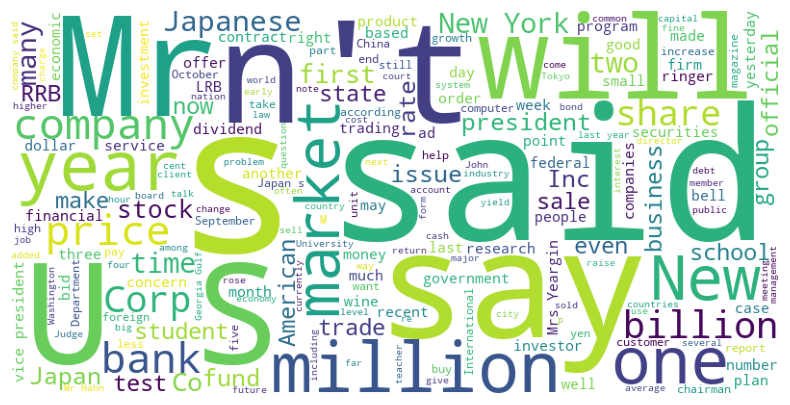

In [10]:
create_wordcloud(train_df)
    

#### Let's analyze the dataset distribution

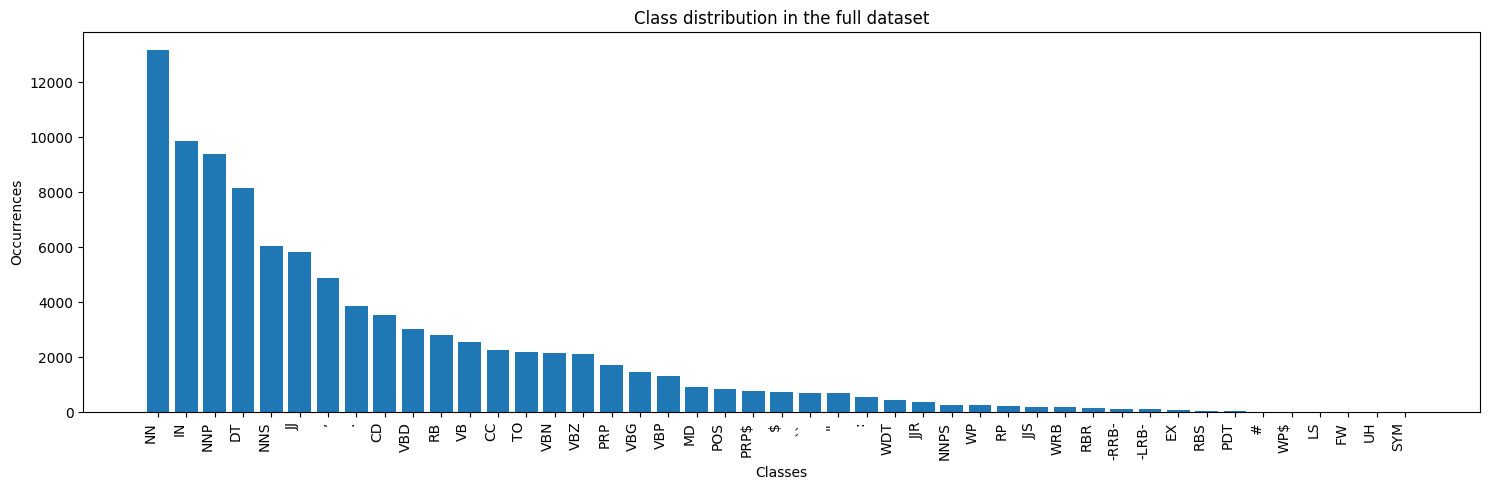

In [11]:
plot_classes_distribution(datasets={'full_dataset': df}, 
                          my_class='POS', 
                          title='Class distribution in the full dataset')           


#### Let's compare the Class distribution in Train, Validation and Test 

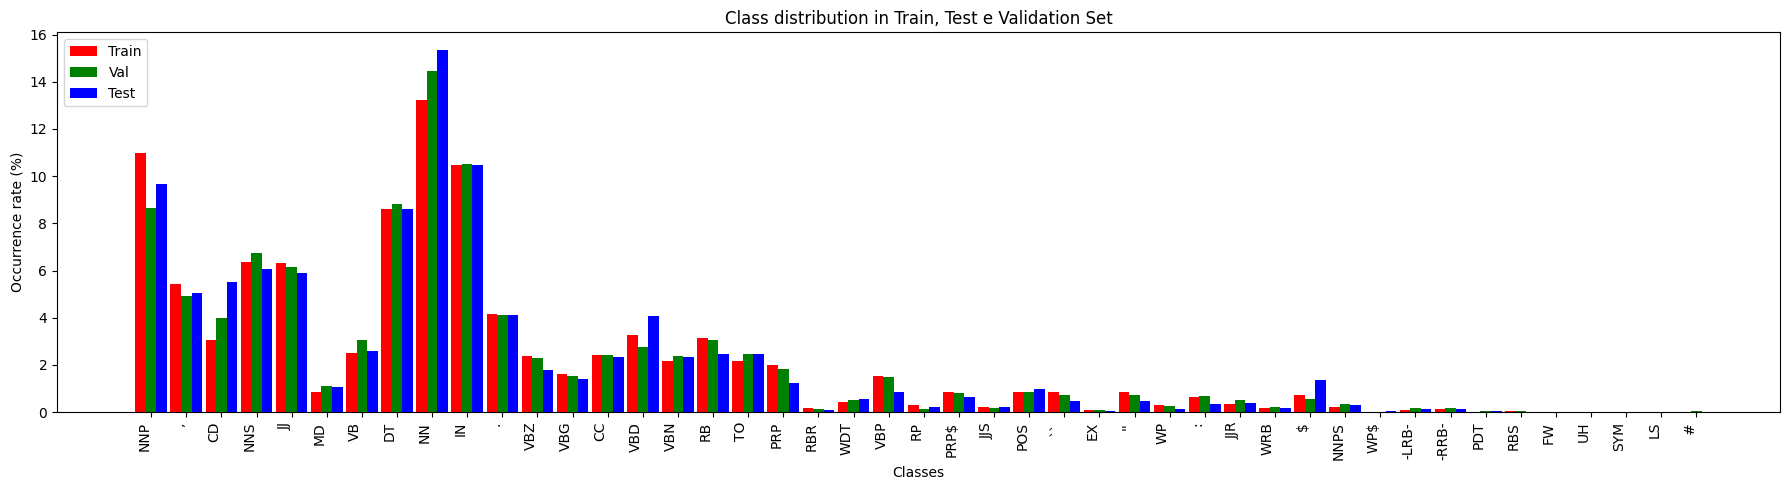

In [12]:
plot_classes_distribution(datasets={'train_dataset': train_df, 'val_dataset': val_df, 'test_dataset': test_df}, 
                          my_class='POS', 
                          title='Class distribution in Train, Test e Validation Set')  

The distribution of each class across the sets is generally uniform, except for a few exceptionally rare classes that are exclusive to specific datasets (e.g., "SYM")

## Task 2

### Extracting our train words and related classes

In [9]:
TRAIN_VOCABULARY = train_df.loc[:, 'WORD'].unique()
CLASSES = df.loc[:, 'POS'].unique()
CLASSES =  np.concatenate((CLASSES, np.array(['<pad>'])))

VOCABULARY_LENGTH = len(TRAIN_VOCABULARY)
N_CLASSES = len(CLASSES)

print(f'The vocabulary that we are gonna use in the training phase contains {VOCABULARY_LENGTH} words')
print(f'The dataset contain {N_CLASSES - 1} Classes')


The vocabulary that we are gonna use in the training phase contains 8009 words
The dataset contain 45 Classes


### Defining same auxiliary maps

In [10]:
WORD_2_INDEX = {word: index for index, word in enumerate(TRAIN_VOCABULARY)}
WORD_2_INDEX['<pad>'] = len(TRAIN_VOCABULARY)
INDEX_2_WORD = {index: word for index, word in enumerate(TRAIN_VOCABULARY)}
INDEX_2_WORD[len(TRAIN_VOCABULARY)] = '<pad>'

CLASS_2_ONE_HOT = {class_label: np.eye(N_CLASSES)[i].astype(float).tolist() for i, class_label in enumerate(CLASSES)}
CLASS_2_INDEX = {key: np.argmax(CLASS_2_ONE_HOT[key]) for key, value in CLASS_2_ONE_HOT.items()}
INDEX_2_CLASS = {value: key for key, value in CLASS_2_INDEX.items()}


 ### Encoding the words and construct the input data and labels for our models

In [11]:
train_sentences, train_pos = build_sentences(train_df)
val_sentences, val_pos = build_sentences(val_df)
test_sentences, test_pos = build_sentences(test_df) 

OOV_EMBEDDING_INDEX = len(TRAIN_VOCABULARY) + 1

train_sentences_mapped = mapping(train_sentences, WORD_2_INDEX, OOV_EMBEDDING_INDEX)
train_pos_mapped = mapping(train_pos, CLASS_2_ONE_HOT, OOV_EMBEDDING_INDEX)

val_sentences_mapped = mapping(val_sentences, WORD_2_INDEX, OOV_EMBEDDING_INDEX)
val_pos_mapped = mapping(val_pos, CLASS_2_ONE_HOT, OOV_EMBEDDING_INDEX)

test_sentences_mapped = mapping(test_sentences, WORD_2_INDEX, OOV_EMBEDDING_INDEX)
test_pos_mapped = mapping(test_pos, CLASS_2_ONE_HOT, OOV_EMBEDDING_INDEX)


## Task 3  & Task 4 & task 5 
 

### Defining the class weights and identify the classes to be excluded during metric computation.

In [12]:
CLASSES_TO_EXCLUDE_1 = [",", ".", "``", "''", ":", "$", "-LRB-", "-RRB-", "#", "<pad>"]                     # Excluded classes in the metric computation
CLASS_INDEXES_TO_EXCLUDE_1 = [CLASS_2_INDEX[pos] for pos in CLASSES_TO_EXCLUDE_1]

CLASSES_TO_EXCLUDE_2 = ['<pad>'] 
CLASS_INDEXES_TO_EXCLUDE_2 = [CLASS_2_INDEX[pos] for pos in CLASSES_TO_EXCLUDE_2]


flattened_pos_index = [CLASS_2_INDEX[pos] for sentence in train_pos for pos in sentence]

w0 = torch.Tensor([0 if c in CLASSES_TO_EXCLUDE_2 else 1 for c in CLASSES]).to(device)                      #exclude the pad class.
w1 = torch.Tensor(create_classes_weights(flattened_pos_index, CLASS_INDEXES_TO_EXCLUDE_1)).to(device)       #exclude the classes in CLASSES_TO_EXCLUDE_1 and compute classes weights for the remaining classes.
w2 = torch.Tensor((create_classes_weights(flattened_pos_index, CLASS_INDEXES_TO_EXCLUDE_2))).to(device)     #exclude the pad class and compute classes weights for the remaining classes.
 
weights_strategies = [w0, w1, w2]


### Searching the hyperparameters for the BaseLine Model

In [24]:
if RUN_BASELINE_GRID_SEARCH:
    
    hyperparameters_key_to_save = ['hidden_size', 'optimizer', 'criterion', 'batch_size']
    seeds = [69, 4, 21]
    
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**i}', optimizer_partial_params={'lr':10 ** i}) for i in range(-2, -5, -1)]
    batch_sizes = [2 ** i for i in range(5, 7)]
    
    criteria_and_early_stoppers = []
    for i, w in enumerate(weights_strategies):
        criterion = Criterion(f'weighted_cross_entropy_{i}', loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=w), reduction_function=torch.mean)
        early_stopper = EarlyStopper(monitor='F1_macro', patience=4, delta=0, mode='max', restore_weights=True)
        criteria_and_early_stoppers.append((criterion, early_stopper))
    
    metrics = [[F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1)]] 
    
    
    model_hyperparameters_to_test = [{'model_class': BaselineModel,
                                      'vocabulary': TRAIN_VOCABULARY,
                                      'embedding_dim': EMBEDDING_DIMENSION,
                                      'glove_model_version': GLOVE_MODEL_VERSION,
                                      'high': HIGH, 
                                      'low': LOW, 
                                      'freeze': False,
                                      'padding_index': VOCABULARY_LENGTH,
                                      'hidden_size': i,
                                      'output_size': N_CLASSES,
                                      'num_layers': 1,
                                     } for i in range(100, 500, 100)]
    
    
    training_hyperparameters_to_test = [{'num_epochs': 200,
                                         'optimizer': p[0],
                                         'batch_size': p[1],
                                         'criterion': p[2][0],
                                         'metrics': p[3],
                                         'early_stopper': p[2][1]
                                         } for p in itertools.product(optimizers, batch_sizes, criteria_and_early_stoppers, metrics)]
    
    
    grid_search_train_validation(train_data=(torch.tensor(train_sentences_mapped), torch.tensor(train_pos_mapped)),
                                 val_data=(torch.tensor(val_sentences_mapped), torch.tensor(val_pos_mapped)),
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BASELINE_GRID_SEARCH_RESULTS_PATH)


100%|██████████| 72/72 [2:27:41<00:00, 123.08s/it]  


#### Grid search results for Baseline model 

In [13]:
BaselineModel_grid_search_results_df = joblib.load(BASELINE_GRID_SEARCH_RESULTS_PATH)
BaselineModel_grid_search_results_df = BaselineModel_grid_search_results_df.sort_values(by='F1_macro_val_mean', ascending=False)
BaselineModel_grid_search_results_df


,hidden_size,optimizer,criterion,batch_size,mean_time,std_time,F1_macro_train_mean,F1_macro_train_std,F1_macro_val_mean,F1_macro_val_std
1,200,Adam lr=0.01,weighted_cross_entropy_0,32,7.866,0.434,0.925058,0.018632,0.770990,0.010112
3,400,Adam lr=0.01,weighted_cross_entropy_0,32,17.866,1.625,0.980780,0.018706,0.770403,0.004862
26,300,Adam lr=0.001,weighted_cross_entropy_0,32,20.876,6.925,0.912479,0.064228,0.768543,0.010953
14,300,Adam lr=0.01,weighted_cross_entropy_0,64,18.871,7.487,0.995341,0.006378,0.768449,0.013135
15,400,Adam lr=0.01,weighted_cross_entropy_0,64,14.234,3.355,0.994795,0.003773,0.765939,0.007600
...,...,...,...,...,...,...,...,...,...,...
69,200,Adam lr=0.0001,weighted_cross_entropy_2,64,58.885,5.855,0.860781,0.017779,0.695464,0.001500
66,300,Adam lr=0.0001,weighted_cross_entropy_1,64,70.428,18.698,0.850941,0.067032,0.689749,0.026732
65,200,Adam lr=0.0001,weighted_cross_entropy_1,64,55.233,11.739,0.845112,0.051621,0.683263,0.019715
71,400,Adam lr=0.0001,weighted_cross_entropy_2,64,67.922,42.631,0.705336,0.277456,0.559147,0.204399


### Searching the hyperparameters for the Model 1

In [26]:
if RUN_MODEL_1_GRID_SEARCH:
    
    hyperparameters_key_to_save = ['hidden_size', 'optimizer', 'criterion', 'batch_size']
    seeds = [69, 4, 21]
    
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**i}', optimizer_partial_params={'lr':10 ** i}) for i in range(-2, -5, -1)]
    batch_sizes = [2 ** i for i in range(5, 7)]
    
    criteria_and_early_stoppers = []
    for i, w in enumerate(weights_strategies):
        criterion = Criterion(f'weighted_cross_entropy_{i}', loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=w), reduction_function=torch.mean)
        early_stopper = EarlyStopper(monitor='F1_macro', patience=4, delta=0, mode='max', restore_weights=True)
        criteria_and_early_stoppers.append((criterion, early_stopper))
    
    metrics = [[F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1)]] 
    
    
    model_hyperparameters_to_test = [{'model_class': Model1,
                                      'vocabulary': TRAIN_VOCABULARY,
                                      'embedding_dim': EMBEDDING_DIMENSION,
                                      'glove_model_version': GLOVE_MODEL_VERSION,
                                      'high': HIGH, 
                                      'low': LOW, 
                                      'freeze': False,
                                      'padding_index': VOCABULARY_LENGTH,
                                      'hidden_size': i,
                                      'output_size': N_CLASSES,
                                      'num_layers': 1,
                                     } for i in range(100, 500, 100)]
    
    
    training_hyperparameters_to_test = [{'num_epochs': 200,
                                         'optimizer': p[0],
                                         'batch_size': p[1],
                                         'criterion': p[2][0],
                                         'metrics': p[3],
                                         'early_stopper': p[2][1]
                                         } for p in itertools.product(optimizers, batch_sizes, criteria_and_early_stoppers, metrics)]
    
    
    grid_search_train_validation(train_data=(torch.tensor(train_sentences_mapped), torch.tensor(train_pos_mapped)),
                                 val_data=(torch.tensor(val_sentences_mapped), torch.tensor(val_pos_mapped)),
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=MODEL_1_GRID_SEARCH_RESULTS_PATH)


100%|██████████| 72/72 [4:55:21<00:00, 246.14s/it]  


#### Grid search results for Model 1 


In [14]:
model_1_grid_search_results_df = joblib.load(MODEL_1_GRID_SEARCH_RESULTS_PATH)
model_1_grid_search_results_df = model_1_grid_search_results_df.sort_values(by='F1_macro_val_mean', ascending=False)

model_1_grid_search_results_df

,hidden_size,optimizer,criterion,batch_size,mean_time,std_time,F1_macro_train_mean,F1_macro_train_std,F1_macro_val_mean,F1_macro_val_std
12,100,Adam lr=0.01,weighted_cross_entropy_0,64,9.650,1.379,0.935173,0.043428,0.766182,0.010747
2,300,Adam lr=0.01,weighted_cross_entropy_0,32,31.320,2.851,0.984132,0.015413,0.763070,0.010845
47,400,Adam lr=0.001,weighted_cross_entropy_2,64,74.510,10.314,0.969960,0.015443,0.760149,0.005426
42,300,Adam lr=0.001,weighted_cross_entropy_1,64,45.385,2.574,0.949358,0.008809,0.759622,0.005687
13,200,Adam lr=0.01,weighted_cross_entropy_0,64,23.215,1.743,0.998924,0.000545,0.759565,0.010067
...,...,...,...,...,...,...,...,...,...,...
68,100,Adam lr=0.0001,weighted_cross_entropy_2,64,93.964,18.787,0.836165,0.046394,0.684582,0.018227
60,100,Adam lr=0.0001,weighted_cross_entropy_0,64,83.333,12.338,0.780574,0.018943,0.677469,0.006360
64,100,Adam lr=0.0001,weighted_cross_entropy_1,64,83.713,52.560,0.628962,0.370601,0.494229,0.274227
69,200,Adam lr=0.0001,weighted_cross_entropy_2,64,95.350,61.370,0.634766,0.377768,0.488572,0.287443


### Searching the hyperparameters for the Model 2


In [28]:
if RUN_MODEL_2_GRID_SEARCH:
    
    hyperparameters_key_to_save = ['hidden_size', 'optimizer', 'criterion', 'batch_size']
    seeds = [69, 4, 21]
    
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**i}', optimizer_partial_params={'lr':10 ** i}) for i in range(-2, -5, -1)]
    batch_sizes = [2 ** i for i in range(5, 7)]
    
    criteria_and_early_stoppers = []
    for i, w in enumerate(weights_strategies):
        criterion = Criterion(f'weighted_cross_entropy_{i}', loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=w), reduction_function=torch.mean)
        early_stopper = EarlyStopper(monitor='F1_macro', patience=4, delta=0, mode='max', restore_weights=True)
        criteria_and_early_stoppers.append((criterion, early_stopper))
    
    metrics = [[F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1)]] 
    
    
    model_hyperparameters_to_test = [{'model_class': Model2,
                                      'vocabulary': TRAIN_VOCABULARY,
                                      'embedding_dim': EMBEDDING_DIMENSION,
                                      'glove_model_version': GLOVE_MODEL_VERSION,
                                      'high': HIGH, 
                                      'low': LOW, 
                                      'freeze': False,
                                      'padding_index': VOCABULARY_LENGTH,
                                      'hidden_size': i,
                                      'output_size': N_CLASSES,
                                      'num_layers': 1,
                                     } for i in range(100, 500, 100)]
    
    
    training_hyperparameters_to_test = [{'num_epochs': 200,
                                         'optimizer': p[0],
                                         'batch_size': p[1],
                                         'criterion': p[2][0],
                                         'metrics': p[3],
                                         'early_stopper': p[2][1]
                                         } for p in itertools.product(optimizers, batch_sizes, criteria_and_early_stoppers, metrics)]
    
    
    grid_search_train_validation(train_data=(torch.tensor(train_sentences_mapped), torch.tensor(train_pos_mapped)),
                                 val_data=(torch.tensor(val_sentences_mapped), torch.tensor(val_pos_mapped)),
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=MODEL_2_GRID_SEARCH_RESULTS_PATH)


100%|██████████| 72/72 [2:29:01<00:00, 124.19s/it]  


#### Grid search results for Model 2 


In [15]:
model_2_grid_search_results_df = joblib.load(MODEL_2_GRID_SEARCH_RESULTS_PATH)
model_2_grid_search_results_df = model_2_grid_search_results_df.sort_values(by='F1_macro_val_mean', ascending=False)

model_2_grid_search_results_df

,hidden_size,optimizer,criterion,batch_size,mean_time,std_time,F1_macro_train_mean,F1_macro_train_std,F1_macro_val_mean,F1_macro_val_std
13,200,Adam lr=0.01,weighted_cross_entropy_0,64,8.276,1.623,0.928076,0.050359,0.775506,0.008733
2,300,Adam lr=0.01,weighted_cross_entropy_0,32,15.323,2.814,0.961245,0.048533,0.772818,0.003772
15,400,Adam lr=0.01,weighted_cross_entropy_0,64,19.883,0.722,0.998838,0.000393,0.772054,0.005042
1,200,Adam lr=0.01,weighted_cross_entropy_0,32,14.141,2.503,0.987678,0.014677,0.768310,0.012181
14,300,Adam lr=0.01,weighted_cross_entropy_0,64,12.562,3.059,0.946582,0.037708,0.765550,0.008517
...,...,...,...,...,...,...,...,...,...,...
50,300,Adam lr=0.0001,weighted_cross_entropy_0,32,73.613,17.210,0.814553,0.058016,0.683303,0.019371
63,400,Adam lr=0.0001,weighted_cross_entropy_0,64,89.805,12.873,0.804969,0.031502,0.682883,0.009647
61,200,Adam lr=0.0001,weighted_cross_entropy_0,64,59.160,3.040,0.773315,0.005913,0.680454,0.004512
62,300,Adam lr=0.0001,weighted_cross_entropy_0,64,87.744,12.159,0.808939,0.038001,0.678423,0.013647


### Extracting the best hyperparameters for our models 

In [16]:
best_hyperparameters_baseline_model = BaselineModel_grid_search_results_df.iloc[0].copy()
best_hyperparameters_model_1 = model_1_grid_search_results_df.iloc[0].copy()
best_hyperparameters_model_2= model_2_grid_search_results_df.iloc[0].copy()

best_hyperparameters_baseline_model['source'] = 'baseline_model'
best_hyperparameters_model_1['source'] = 'model_1'
best_hyperparameters_model_2['source'] = 'model_2'

best_hyperparameters_df = pd.concat([best_hyperparameters_baseline_model, best_hyperparameters_model_1, best_hyperparameters_model_2], 
                                    ignore_index=True, 
                                    axis=1).T
best_hyperparameters_df.set_index('source', inplace=True)

best_hyperparameters_df

,hidden_size,optimizer,criterion,batch_size,mean_time,std_time,F1_macro_train_mean,F1_macro_train_std,F1_macro_val_mean,F1_macro_val_std
source,,,,,,,,,,
baseline_model,200,Adam lr=0.01,weighted_cross_entropy_0,32,7.866,0.434,0.925058,0.018632,0.77099,0.010112
model_1,100,Adam lr=0.01,weighted_cross_entropy_0,64,9.65,1.379,0.935173,0.043428,0.766182,0.010747
model_2,200,Adam lr=0.01,weighted_cross_entropy_0,64,8.276,1.623,0.928076,0.050359,0.775506,0.008733


### Creating the directory to save the weights for our models


In [17]:
if not os.path.exists(WEIGHTS_DIRECTORY):
    os.makedirs(WEIGHTS_DIRECTORY )
    

### Creating and training our Baseline model 

In [20]:
baseline_optimizer = best_hyperparameters_df.loc['baseline_model','optimizer']
baseline_hidden_size = best_hyperparameters_df.loc['baseline_model','hidden_size']
baseline_criterion = best_hyperparameters_df.loc['baseline_model','criterion']
baseline_batch_size = best_hyperparameters_df.loc['baseline_model','batch_size']


train_data_loader = get_data_loader(data=torch.tensor(train_sentences_mapped),
                                    label=torch.tensor(train_pos_mapped), 
                                    batch_size=int(baseline_batch_size), 
                                    shuffle=True)

val_data_loader = get_data_loader(data=torch.tensor(val_sentences_mapped),
                                  label=torch.tensor(val_pos_mapped), 
                                  batch_size=int(baseline_batch_size), 
                                  shuffle=False)


my_baseline_model = BaselineModel(vocabulary=TRAIN_VOCABULARY, 
                                  embedding_dim=EMBEDDING_DIMENSION,
                                  glove_model_version=GLOVE_MODEL_VERSION,
                                  high=HIGH, 
                                  low=LOW, 
                                  freeze=False,
                                  padding_index=VOCABULARY_LENGTH,
                                  hidden_size=int(baseline_hidden_size), 
                                  output_size=N_CLASSES,
                                  num_layers=1).to(device)

baseline_embedding_matrix_before_training = my_baseline_model.get_embedding_weights_clone()

if FIT_BASELINE:

    my_baseline_model_history = my_baseline_model.fit(train_loader=train_data_loader, 
                                                      val_loader=val_data_loader, 
                                                      criterion=baseline_criterion, 
                                                      metrics=[F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1)], 
                                                      optimizer=baseline_optimizer,
                                                      early_stopper=EarlyStopper(monitor='F1_macro', patience=4, delta=0, mode='max', restore_weights=True),
                                                      num_epochs=200)
    
    torch.save(my_baseline_model.state_dict(), BASELINE_WEIGHTS_PATH)

else:
    my_baseline_model.load_state_dict(torch.load(BASELINE_WEIGHTS_PATH))

baseline_embedding_matrix_after_training = my_baseline_model.get_embedding_weights_clone()


 Epoch: 1/200 Iterations: 61/61 Time: 1.634s - weighted_cross_entropy_0: 0.007559936027974 - F1_macro: 0.82929412399767 - val_weighted_cross_entropy_0: 0.114202529191971 - val_F1_macro: 0.72484318062362 
 Epoch: 2/200 Iterations: 61/61 Time: 1.327s - weighted_cross_entropy_0: 0.00321970321238 - F1_macro: 0.902740551203985 - val_weighted_cross_entropy_0: 0.123739644885063 - val_F1_macro: 0.730919834008936 
 Epoch: 3/200 Iterations: 61/61 Time: 1.266s - weighted_cross_entropy_0: 0.001591831212863 - F1_macro: 0.962500908229635 - val_weighted_cross_entropy_0: 0.122425757348537 - val_F1_macro: 0.753517791172218 
 Epoch: 4/200 Iterations: 61/61 Time: 1.366s - weighted_cross_entropy_0: 0.000876459525898 - F1_macro: 0.992639625882897 - val_weighted_cross_entropy_0: 0.126429006457329 - val_F1_macro: 0.759710761039948 
 Epoch: 5/200 Iterations: 61/61 Time: 1.357s - weighted_cross_entropy_0: 0.000500233727507 - F1_macro: 0.995625203197604 - val_weighted_cross_entropy_0: 0.135064363479614 - val_F1

### Plotting the training and validation history for our Baseline model

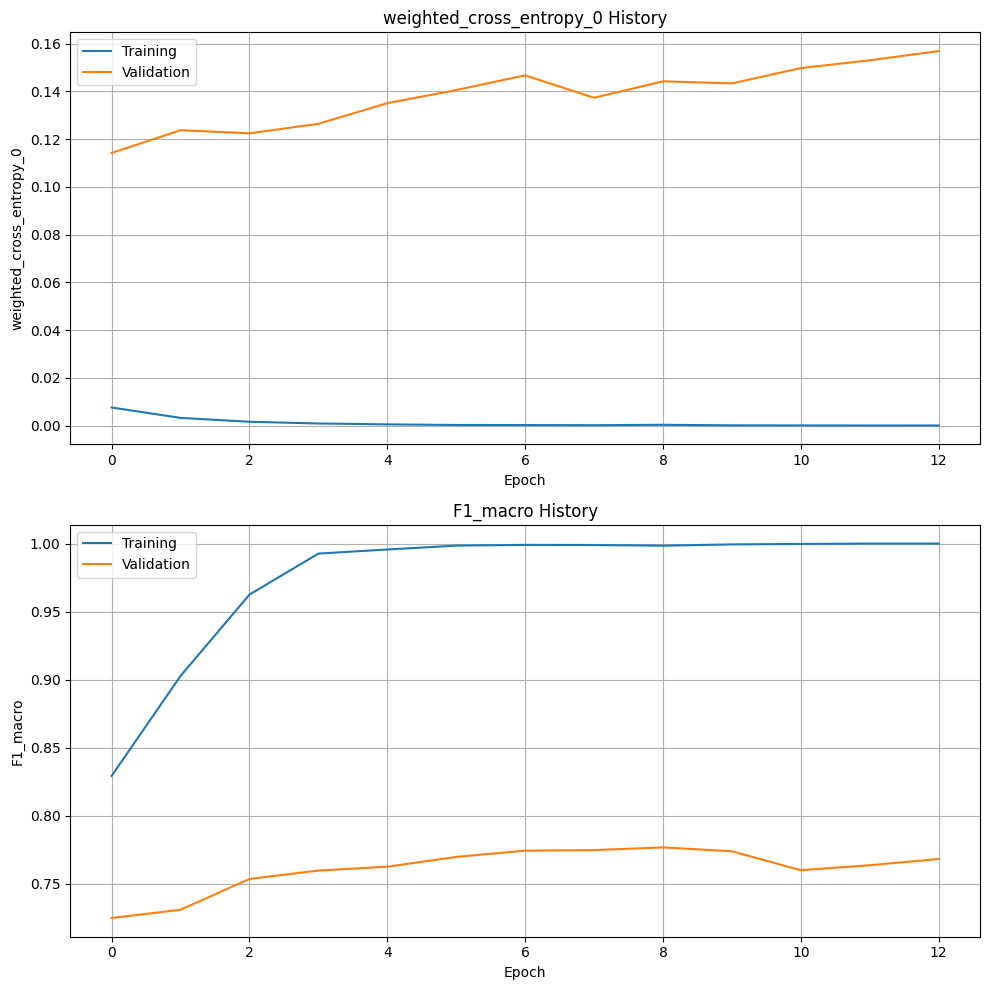

In [21]:
if FIT_BASELINE:
    plot_history(my_baseline_model_history)


### Creating and training our Model 1 


In [22]:
model_1_optimizer = best_hyperparameters_df.loc['model_1','optimizer']
model_1_hidden_size = best_hyperparameters_df.loc['model_1','hidden_size']
model_1_criterion = best_hyperparameters_df.loc['model_1','criterion']
model_1_batch_size = best_hyperparameters_df.loc['model_1','batch_size']


train_data_loader = get_data_loader(data=torch.tensor(train_sentences_mapped),
                                    label=torch.tensor(train_pos_mapped), 
                                    batch_size=int(model_1_batch_size), 
                                    shuffle=True)

val_data_loader = get_data_loader(data=torch.tensor(val_sentences_mapped),
                                  label=torch.tensor(val_pos_mapped), 
                                  batch_size=int(model_1_batch_size), 
                                  shuffle=False)


my_model_1 = Model1(vocabulary=TRAIN_VOCABULARY, 
                    embedding_dim=EMBEDDING_DIMENSION,
                    glove_model_version=GLOVE_MODEL_VERSION,
                    high=HIGH, 
                    low=LOW, 
                    freeze=False,
                    padding_index=VOCABULARY_LENGTH,
                    hidden_size=int(model_1_hidden_size), 
                    output_size=N_CLASSES,
                    num_layers=1).to(device)

model_1_embedding_matrix_before_training = my_model_1.get_embedding_weights_clone()

if FIT_MODEL_1:

    my_model_1_history = my_model_1.fit(train_loader=train_data_loader, 
                                        val_loader=val_data_loader, 
                                        criterion=model_1_criterion, 
                                        metrics=[F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1)], 
                                        optimizer=model_1_optimizer,
                                        early_stopper=EarlyStopper(monitor='F1_macro', patience=4, delta=0, mode='max', restore_weights=True),
                                        num_epochs=200)
    
    torch.save(my_model_1.state_dict(), MODEL_1_WEIGHTS_PATH)

else:
    my_model_1.load_state_dict(torch.load(MODEL_1_WEIGHTS_PATH))
    
model_1_embedding_matrix_after_training = my_model_1.get_embedding_weights_clone()


 Epoch: 1/200 Iterations: 31/31 Time: 1.061s - weighted_cross_entropy_0: 0.021241318434477 - F1_macro: 0.66620449017105 - val_weighted_cross_entropy_0: 0.148422703146934 - val_F1_macro: 0.609894595242273 
 Epoch: 2/200 Iterations: 31/31 Time: 1.072s - weighted_cross_entropy_0: 0.00689402455464 - F1_macro: 0.805741194993053 - val_weighted_cross_entropy_0: 0.128814980387688 - val_F1_macro: 0.687690738892948 
 Epoch: 3/200 Iterations: 31/31 Time: 1.065s - weighted_cross_entropy_0: 0.003483252599835 - F1_macro: 0.871203853569057 - val_weighted_cross_entropy_0: 0.142256900668144 - val_F1_macro: 0.758053751982939 
 Epoch: 4/200 Iterations: 31/31 Time: 1.062s - weighted_cross_entropy_0: 0.002031769603491 - F1_macro: 0.894054235159582 - val_weighted_cross_entropy_0: 0.145043358206749 - val_F1_macro: 0.780632650358579 
 Epoch: 5/200 Iterations: 31/31 Time: 1.102s - weighted_cross_entropy_0: 0.001293284236453 - F1_macro: 0.914090268961713 - val_weighted_cross_entropy_0: 0.169624075293541 - val_F

### Plotting train and validation history for our Model 1


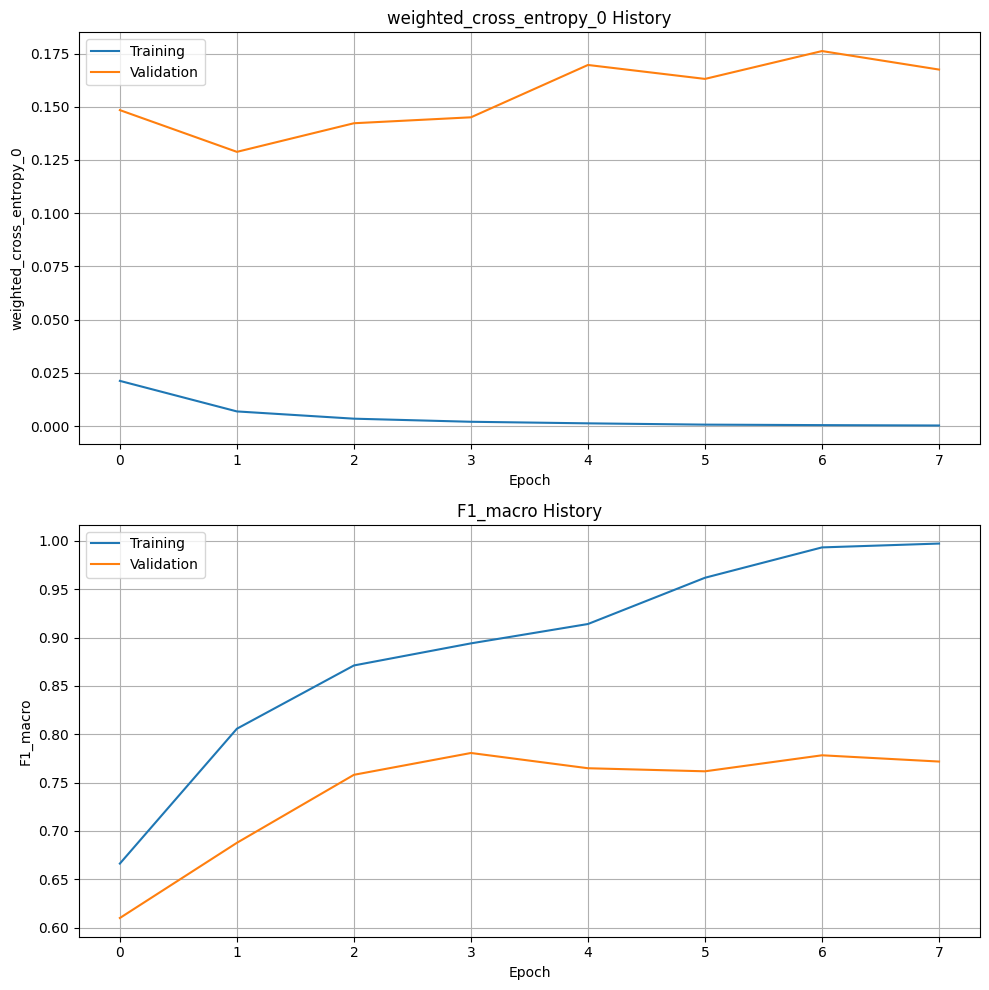

In [23]:
if FIT_MODEL_1:
    plot_history(my_model_1_history)


### Creating and training our Model 2 

In [28]:
model_2_optimizer = best_hyperparameters_df.loc['model_2','optimizer']
model_2_hidden_size = best_hyperparameters_df.loc['model_2','hidden_size']
model_2_criterion = best_hyperparameters_df.loc['model_2','criterion']
model_2_batch_size = best_hyperparameters_df.loc['model_2','batch_size']


train_data_loader = get_data_loader(data=torch.tensor(train_sentences_mapped),
                                    label=torch.tensor(train_pos_mapped), 
                                    batch_size=int(model_2_batch_size), 
                                    shuffle=True)

val_data_loader = get_data_loader(data=torch.tensor(val_sentences_mapped),
                                  label=torch.tensor(val_pos_mapped), 
                                  batch_size=int(model_2_batch_size), 
                                  shuffle=False)


my_model_2 = Model2(vocabulary=TRAIN_VOCABULARY, 
                    embedding_dim=EMBEDDING_DIMENSION,
                    glove_model_version=GLOVE_MODEL_VERSION,
                    high=HIGH, 
                    low=LOW, 
                    freeze=False,
                    padding_index=VOCABULARY_LENGTH,
                    hidden_size=int(model_2_hidden_size), 
                    output_size=N_CLASSES,
                    num_layers=1).to(device)

model_2_embedding_matrix_before_training = my_model_2.get_embedding_weights_clone()

if FIT_MODEL_2:

    my_model_2_history = my_model_2.fit(train_loader=train_data_loader, 
                                        val_loader=val_data_loader, 
                                        criterion=model_2_criterion, 
                                        metrics=[F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1)], 
                                        optimizer=model_2_optimizer,
                                        early_stopper=EarlyStopper(monitor='F1_macro', patience=4, delta=0, mode='max', restore_weights=True),
                                        num_epochs=200)
    
    torch.save(my_model_2.state_dict(), MODEL_2_WEIGHTS_PATH)
    
else:
    my_model_2.load_state_dict(torch.load(MODEL_2_WEIGHTS_PATH))
    
model_2_embedding_matrix_after_training = my_model_2.get_embedding_weights_clone()


 Epoch: 1/200 Iterations: 31/31 Time: 1.024s - weighted_cross_entropy_0: 0.022907493636012 - F1_macro: 0.595301057072856 - val_weighted_cross_entropy_0: 0.157818377017975 - val_F1_macro: 0.532117407728964 
 Epoch: 2/200 Iterations: 31/31 Time: 0.992s - weighted_cross_entropy_0: 0.006151000969112 - F1_macro: 0.796056637969089 - val_weighted_cross_entropy_0: 0.137594312429428 - val_F1_macro: 0.685727165818825 
 Epoch: 3/200 Iterations: 31/31 Time: 0.963s - weighted_cross_entropy_0: 0.00306233856827 - F1_macro: 0.879363314645055 - val_weighted_cross_entropy_0: 0.14531809091568 - val_F1_macro: 0.729701886509962 
 Epoch: 4/200 Iterations: 31/31 Time: 0.97s - weighted_cross_entropy_0: 0.002048371359706 - F1_macro: 0.867816811188122 - val_weighted_cross_entropy_0: 0.139193639159203 - val_F1_macro: 0.72408362048528 
 Epoch: 5/200 Iterations: 31/31 Time: 0.947s - weighted_cross_entropy_0: 0.000839566579089 - F1_macro: 0.934805862445959 - val_weighted_cross_entropy_0: 0.143162354826927 - val_F1_

### Plotting the training and validation history for our Model 2


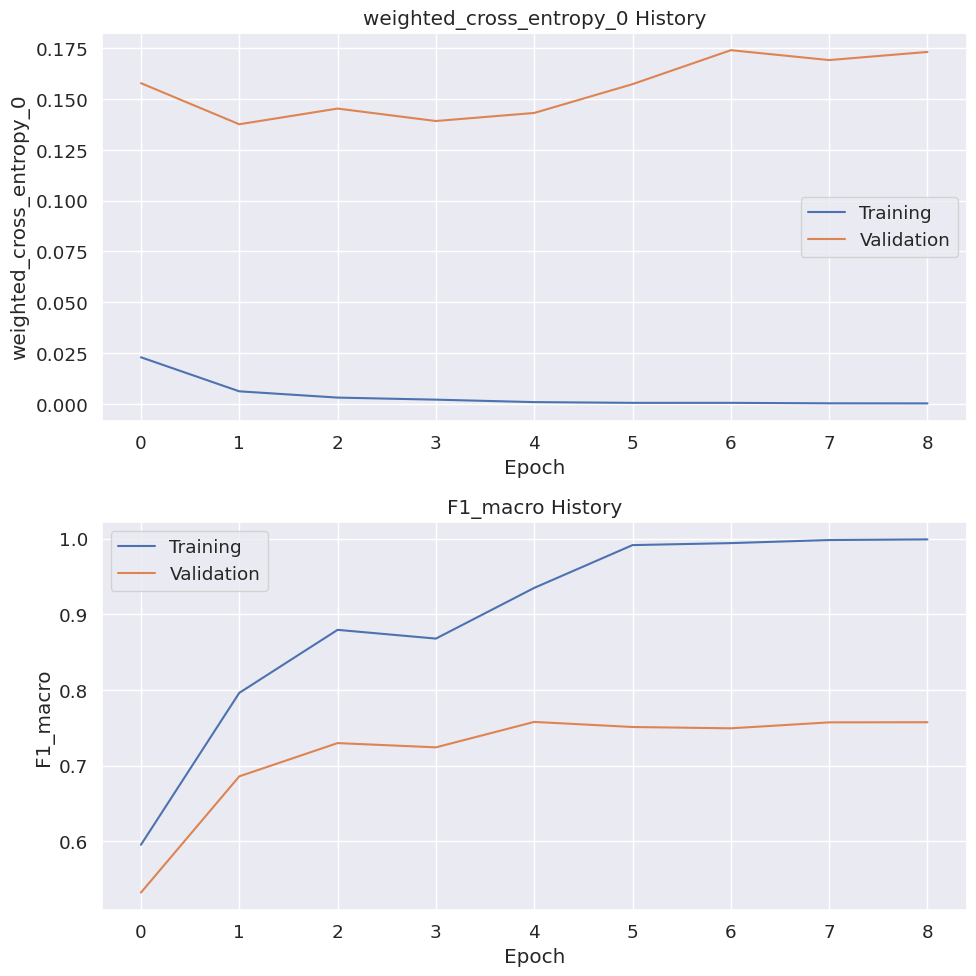

In [29]:
if FIT_MODEL_2:
    plot_history(my_model_2_history)


### Let's visualize how the training process change our embeddings 

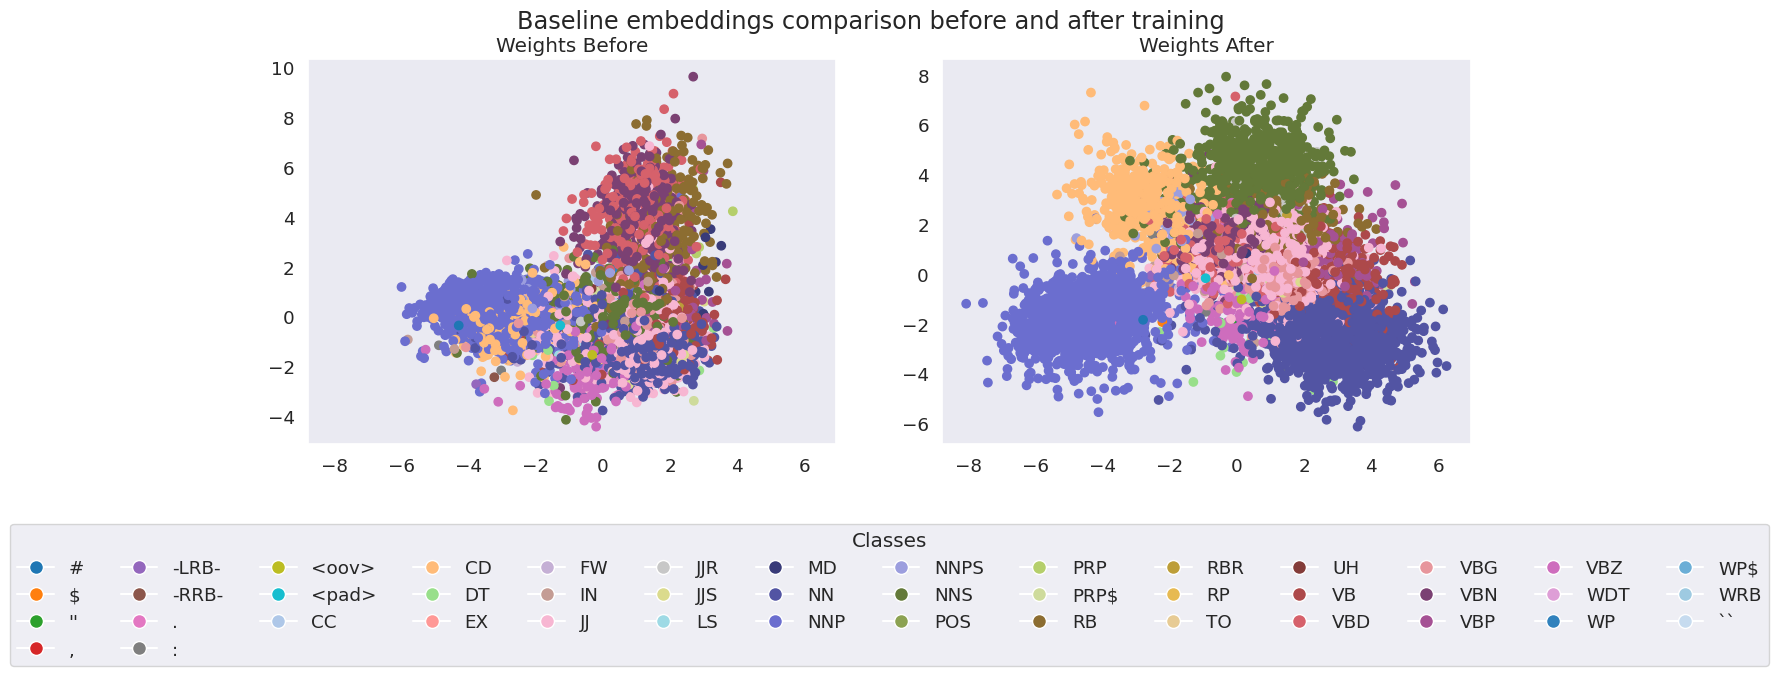

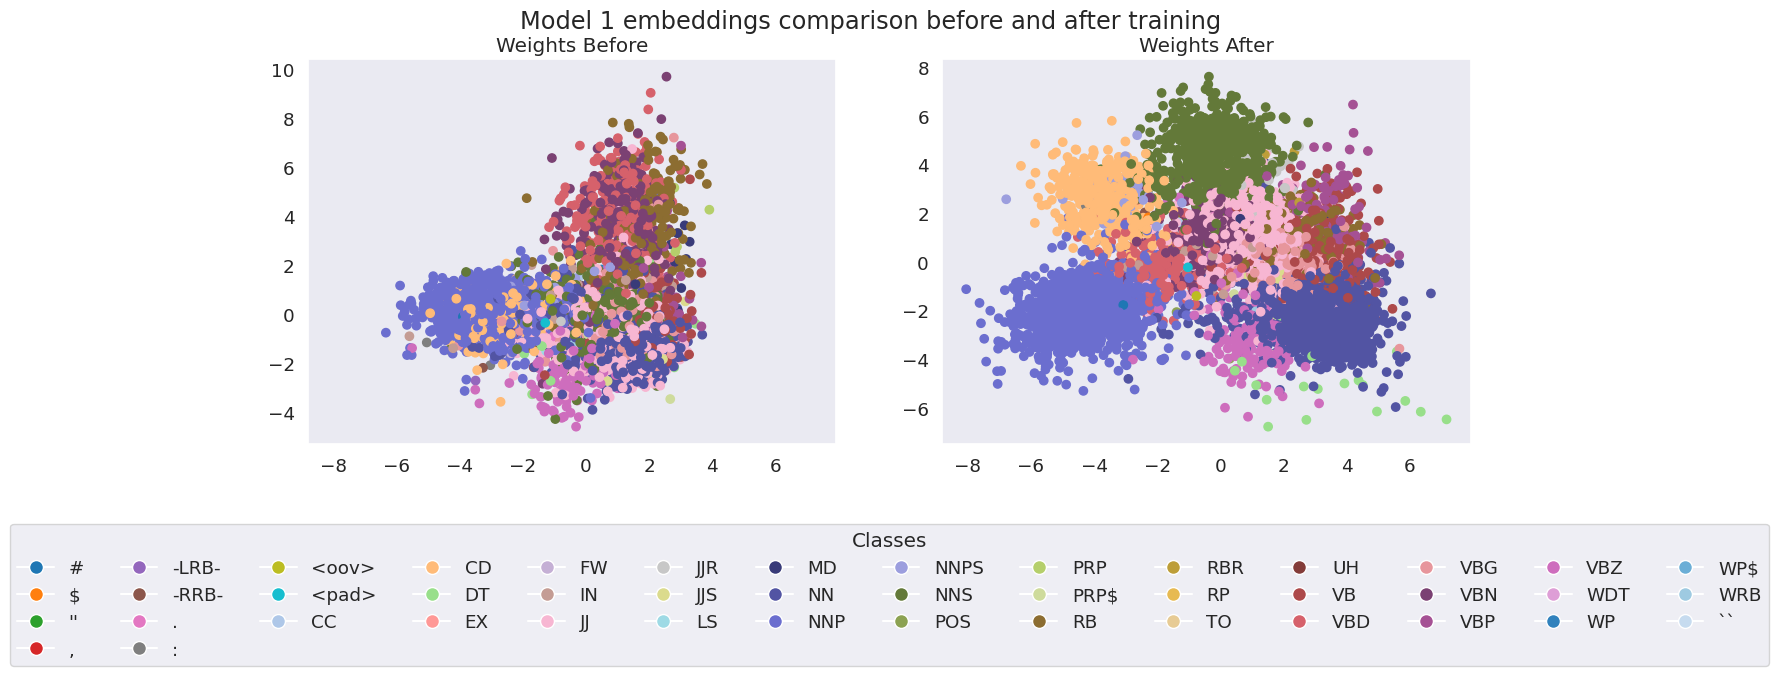

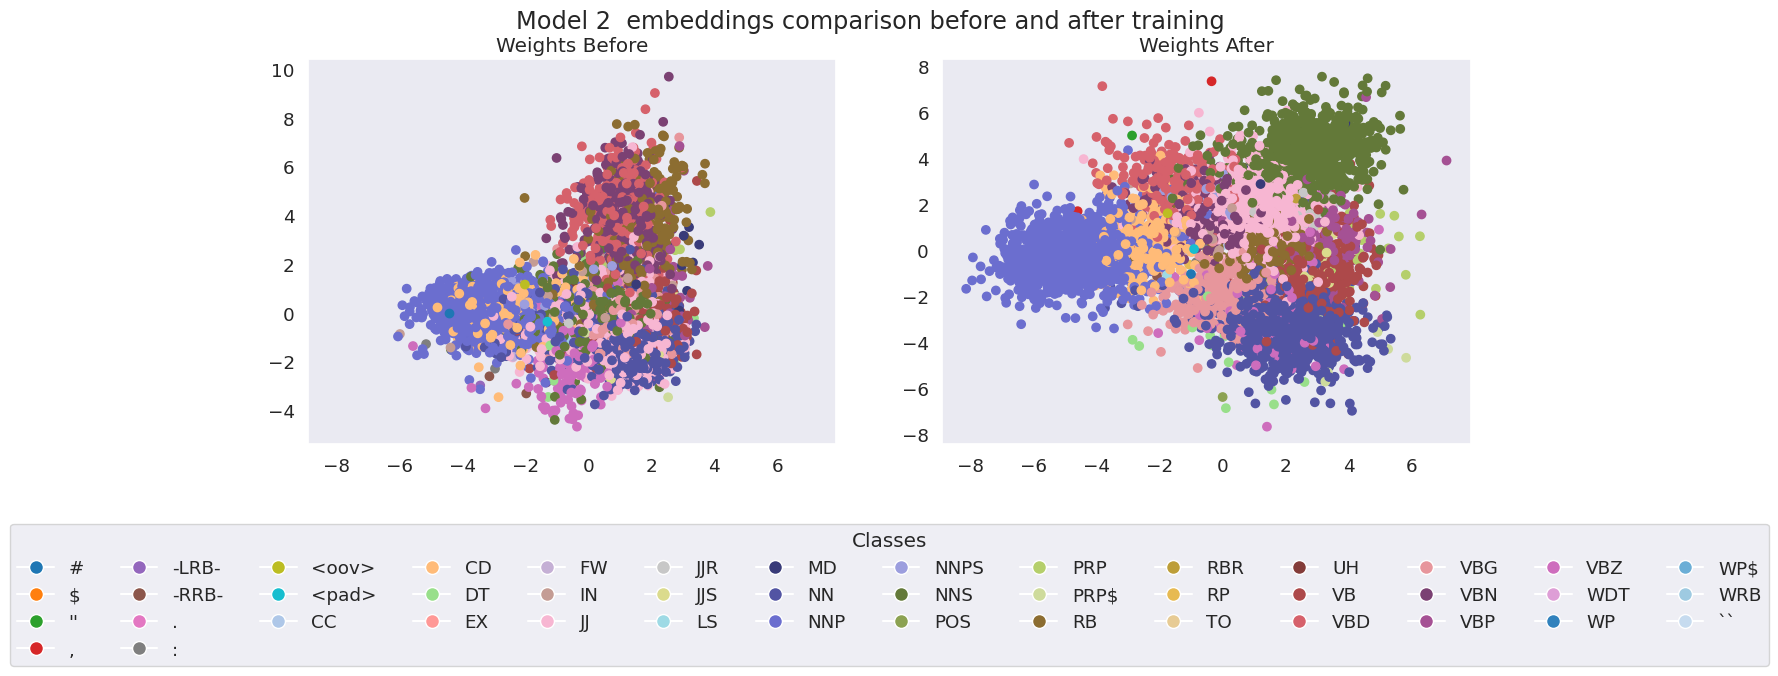

In [30]:
TRAIN_VOCABULARY_TMP = np.append(TRAIN_VOCABULARY, '<pad>')
TRAIN_VOCABULARY_TMP = np.append(TRAIN_VOCABULARY_TMP, '<oov>')
classes = train_df.drop_duplicates(subset='WORD')['POS'].to_numpy()

classes = np.append(classes, '<pad>')
classes = np.append(classes, '<oov>')

word_and_class = np.column_stack((TRAIN_VOCABULARY_TMP, classes))

baseline_embeddings_before_training = np.column_stack((word_and_class, baseline_embedding_matrix_before_training.cpu().detach().numpy()))
baseline_embeddings_after_training = np.column_stack((word_and_class, baseline_embedding_matrix_after_training.cpu().detach().numpy()))

model_1_embeddings_before_training = np.column_stack((word_and_class, model_1_embedding_matrix_before_training.cpu().detach().numpy()))
model_1_embeddings_after_training = np.column_stack((word_and_class, model_1_embedding_matrix_after_training.cpu().detach().numpy()))

model_2_embeddings_before_training = np.column_stack((word_and_class, model_2_embedding_matrix_before_training.cpu().detach().numpy()))
model_2_embeddings_after_training = np.column_stack((word_and_class, model_2_embedding_matrix_after_training.cpu().detach().numpy()))


unique_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
                 '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
                 '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939',
                 '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39',
                 '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b',
                 '#e7969c', '#7b4173', '#a55194', '#ce6dbd', '#de9ed6',
                 '#3182bd', '#6baed6', '#9ecae1', '#c6dbef', '#e6550d']

colors = np.array(unique_colors)

plot_dimensionality_reduction(baseline_embeddings_before_training, 
                              baseline_embeddings_after_training, 
                              title='Baseline embeddings comparison before and after training', 
                              colors=colors)

plot_dimensionality_reduction(model_1_embeddings_before_training, 
                              model_1_embeddings_after_training, 
                              title='Model 1 embeddings comparison before and after training', 
                              colors=colors)

plot_dimensionality_reduction(model_2_embeddings_before_training, 
                              model_2_embeddings_after_training, 
                              title='Model 2  embeddings comparison before and after training', 
                              colors=colors)


## Task 6

### Analyzing the Test and Validation errors

The value of the F1 macro score obtained by our Model 2 on the Test set is: 0.830585055257295
The value of the F1 macro score obtained by our Model 2 on the Validation set is: 0.7793393168327452


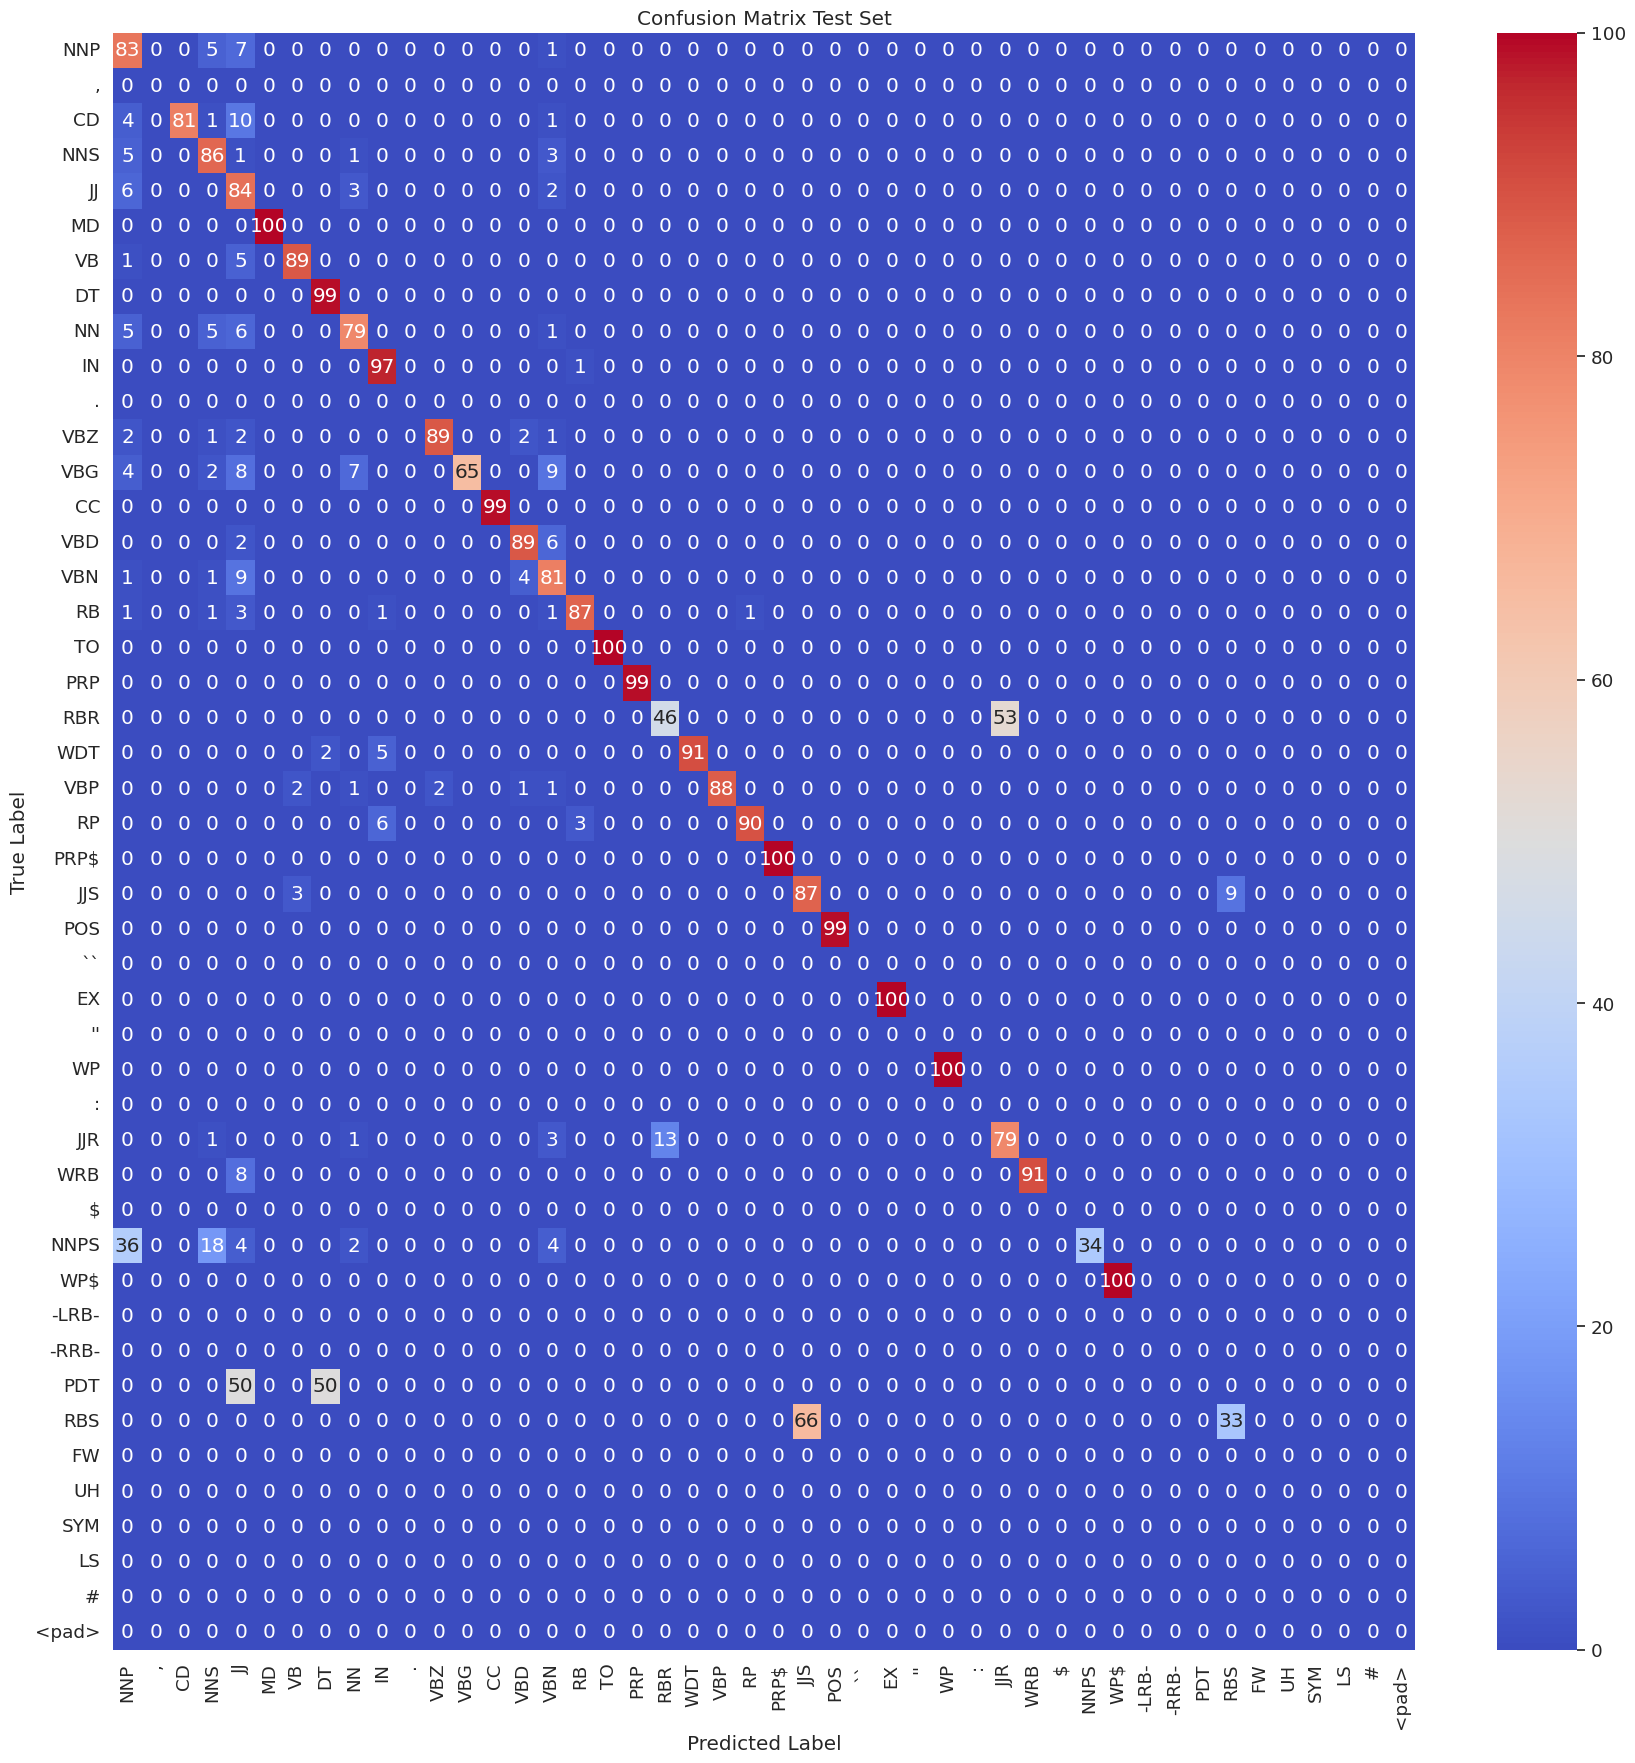

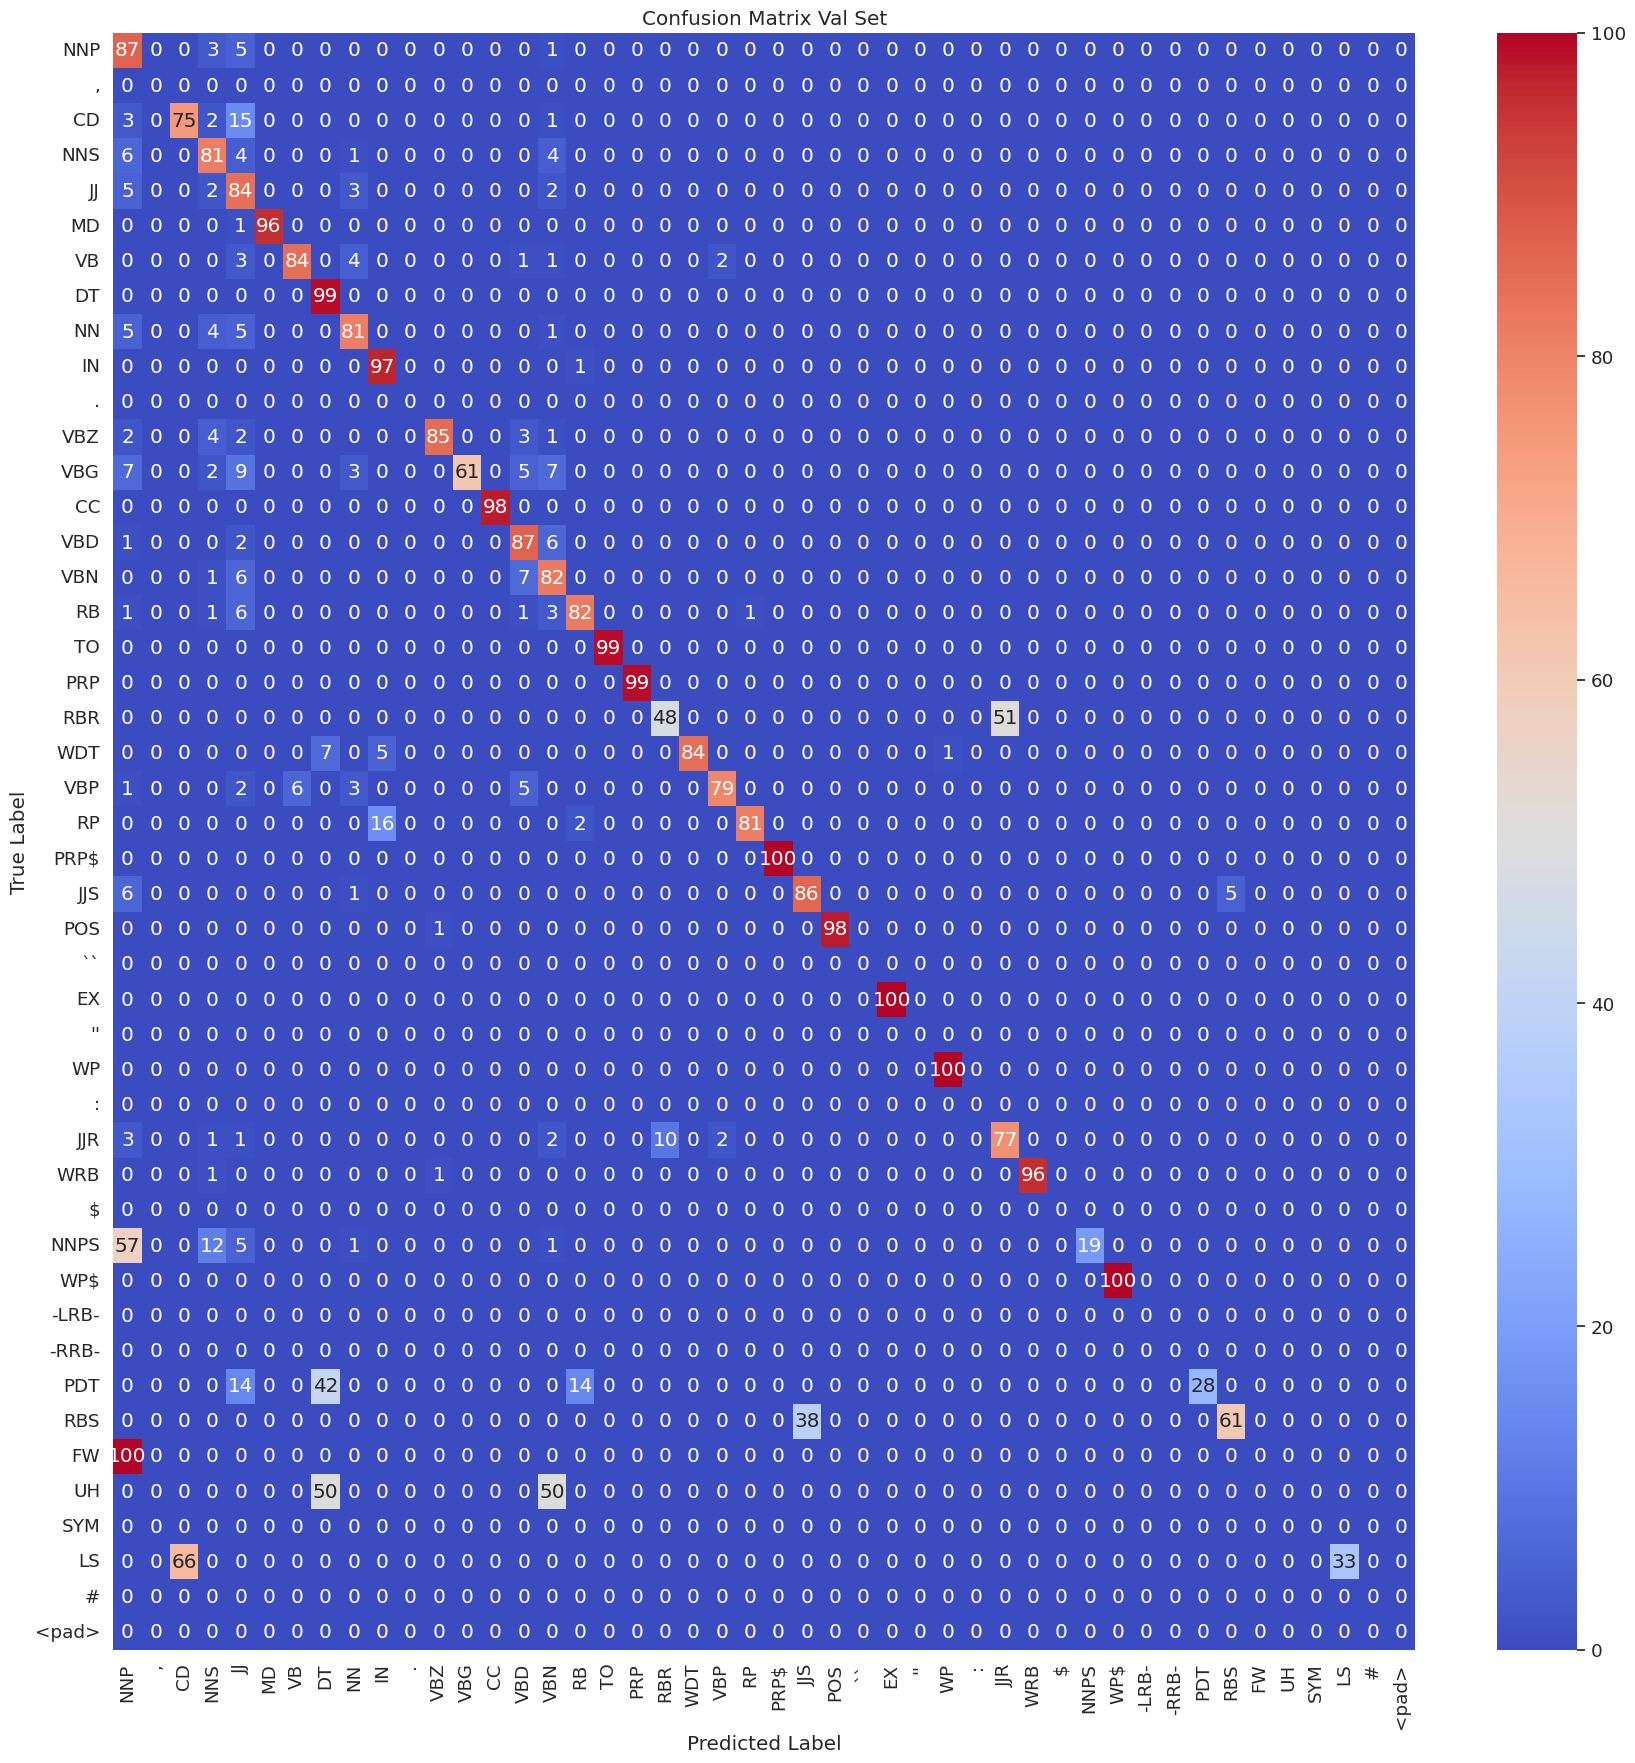

In [31]:
test_predicted_labels = my_model_2.predict(torch.tensor(test_sentences_mapped, device='cpu'))
val_predicted_labels = my_model_2.predict(torch.tensor(val_sentences_mapped, device='cpu'))

test_predicted_labels_flat = test_predicted_labels.numpy().flatten().astype(int)
val_predicted_labels_flat = val_predicted_labels.numpy().flatten().astype(int)

test_true_label_flat = np.concatenate([np.array([CLASS_2_INDEX[pos] for pos in sentence]) for sentence in test_pos]).astype(int)
val_true_label_flat = np.concatenate([np.array([CLASS_2_INDEX[pos] for pos in sentence]) for sentence in val_pos]).astype(int)

test_mask = ~np.isin(test_true_label_flat, CLASS_INDEXES_TO_EXCLUDE_1)
val_mask = ~np.isin(val_true_label_flat, CLASS_INDEXES_TO_EXCLUDE_1)

test_cm = confusion_matrix(test_true_label_flat[test_mask], test_predicted_labels_flat[test_mask], labels=list(INDEX_2_CLASS.keys()))
val_cm = confusion_matrix(val_true_label_flat[val_mask], val_predicted_labels_flat[val_mask], labels=list(INDEX_2_CLASS.keys()))

test_cm_normalized_true = test_cm / (np.sum(test_cm, axis=1, keepdims=True) + np.finfo(float).eps)
val_cm_normalized_true = val_cm / (np.sum(val_cm, axis=1, keepdims=True) + np.finfo(float).eps)

classes_indexes_not_in_test = np.setdiff1d(np.arange(N_CLASSES), np.unique(test_true_label_flat)).tolist()
classes_indexes_not_in_val = np.setdiff1d(np.arange(N_CLASSES), np.unique(val_true_label_flat)).tolist()

test_f1_metric = F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1 + classes_indexes_not_in_test)
val_f1_metric = F1_Score('F1_macro', N_CLASSES, mode='macro', classes_to_exclude=CLASS_INDEXES_TO_EXCLUDE_1 + classes_indexes_not_in_val)

test_f1_score = test_f1_metric(torch.tensor(test_predicted_labels_flat), torch.tensor(test_true_label_flat)) 
val_f1_score = val_f1_metric(torch.tensor(val_predicted_labels_flat), torch.tensor(val_true_label_flat)) 

print(f'The value of the F1 macro score obtained by our Model 2 on the Test set is: {test_f1_score}')
print(f'The value of the F1 macro score obtained by our Model 2 on the Validation set is: {val_f1_score}')

plot_confusion_matrix((test_cm_normalized_true*100).astype(int), list(CLASS_2_INDEX.keys()), figsize=(21, 21), title="Confusion Matrix Test Set")
plot_confusion_matrix((val_cm_normalized_true*100).astype(int), list(CLASS_2_INDEX.keys()), figsize=(21, 21), title="Confusion Matrix Val Set")
